# Load libraries

In [1]:
%load_ext autoreload
%autoreload 2



# Basic libraries
import pandas as pd
import numpy as np
import sys


# Scipy
import scipy
from scipy import signal
from scipy.linalg import solve
from scipy import constants
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq

# Locate files
import os
from pathlib import Path
from glob import glob

# Plots
from matplotlib import pyplot as plt

#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data
from joblib import Parallel, delayed

""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs

from   SEA import SEA
import three_D_funcs as threeD
import download_data as download

sys.path.insert(1, os.path.join(os.getcwd(), 'functions/3d_anis_analysis_toolboox'))
import collect_wave_coeffs 
import data_analysis 



os.environ["CDF_LIB"] = "/Applications/cdf/cdf/lib"

/Users/nokni/work/MHDTurbPy/pyspedas/pyspedas/__init__.py
This unreleased version of SpacePy is not supported by the SpacePy team.


# Download data

In [4]:

#User defined parameters 

cdf_lib_path            = '/Applications/cdf/cdf/lib'            # You will need to read cdf files. You have to specify the path

""" At this point you NEED credentials for function to work. This is because of the ephemeris data! Let me know if this doesnt work"""
# credentials             =      { 'psp':{
#                                            'fields': {'username': None, 'password': None},
#                                            'sweap' : {'username': None, 'password': None}}}

credentials             =      { 'psp':{
                                           'fields': {'username': 'mvelli', 'password': 'flds@psp'},
                                           'sweap' : {'username': 'mvelli', 'password': '2019swe@pd@ta'}}}



settings                =  {
    
                    ###____How to handle data ____###
    
                            'Data_path'              : '/Volumes/Zesen-4TB/SPEDAS/',  # Path were pyspedas downloads data
                            'save_destination'       : '/Users/nokni/work/MHDTurbPy/examples/',
                            'use_local_data'         :  False,                        # Whether to donwload data(again) or use local data
                            'overwrite_files'        :  1,                            # In case you want to re-do analysis for existing files!
                            'save_all'               :  True,                         # If false it will only keep derived quants. Not timeseries
                            'addit_time_around'      :  4,                            # When loading at first it will return [start_time -addit_time_around [h], end_time + addit_time_around [h]]. The data are cut to the right dates later
                            'gap_time_threshold'     :  5 ,                           # Threshold for large gaps (units of seconds)
    
                     ###____Basics for the intervals ____###   
                            'sc'                     : 'PSP',                         # Choices ['PSP', SOLO, 'HELIOS_A', 'HELIOS_B', 'WIND']
                            'in_rtn'                 :  1,                          # RTN or spacecraft frame ( We will usually use RTN)
                            'Only_1_interval'        :  True,                         # If you only want to check one interval
                            'start_date'             : '2018-11-04 02:00', 
                            'end_date'               : '2018-11-04 05:00',
                            'must_have_qtn'          :  0,                            # Dont consider interval if no qtn data. Only matters for PSP & SOLO
                            'Max_par_missing'        :  30,                           # Maximum fraction of missing particle data allowed
                            'particle_mode'          : '9th_perih_cut',               # Only for PSP: either: 'spc', 'span', '9th_perih_cut'
                            'max_PSP_dist'           : 0.4,                           # Maximum PSP distance to consider [au]
                            'part_resol'             : 300,                           # Max resol of plasma data                [ms]
                            'MAG_resol'              : 235,                             # Max resol og magnetic field data        [ms] [<230: Full resol mag data, >230 : 4_sa_per_sec dataset]
                            'upsample_low_freq_ts'   : False,                         # False: Whether to downsample mag data (after applying low-pass filter to make them match the cadence of velocity field data 

                    
                        ###____Only matters if 'Only_1_interval' ==False. It will essentially download adjacent intervals overlaping by 'Step'____###
                            'duration'               : '24H',                         # Duration of interval (in Hours)
                            'Step'                   : '12H',                         # Move starting point by step (in Hours)
                            'cut_in_small_windows'   : {
                                                        'flag'    : False, 
                                                        'Step'    : '10min',          # Cuts each  larger interval in small windows. To avoid loading data again and again (Too slow)
                                                        'duration': '600min'},  

    
                     ###____Additional diagnostics ____###  
    
                            'estimate_derived_param' : True,
                            'rol_window'             : '60min',                          # When estimating fluctuations, size of window (centered around -w/2 -w/2
                            'apply_hampel'           : False,                         # Use hampelfilter to despike plasma data
                            'hampel_params'          : {'w':200, 'std':3},
                                                                                      # True : Upsample velocity field data
    
                            'estimate_psd_b'         : 1,                             # Estimate magentic field powes spectral density (keep false)
                            'estimate_psd_v'         : 1,                             # Estimate velocity field powes spectral density (keep false)
                            'est_PSD_components'     : 1,
                            'smooth_psd'             : False,
                            'Big_Gaps'               :{
                                                        'Mag_big_gaps' : 500,
                                                        'Par_big_gaps' : 5000,           # A file will be returned where gaps in the timeseries (larger than
                                                        'QTN_big_gaps' : 3000,          # those specified here [s]) are shown. This will enable the user to 
                                                                                       # omit the gappy data later
                                                        }                             

                            } 


# You can chnage those if more data are needed. Check /downloading_helpers/ PSP or SOLO to find default data to be downloaded
if settings['sc'] == "PSP":
    
    if settings['in_rtn']:
        vars_2_downnload = {
                            'mag'    : None, 
                            'span'   : None,
                            'span-a' : None,
                            'spc'    : None, 
                            'qtn'    : None,
                            'ephem'  : None}
    else:
        vars_2_downnload = {
                            'mag'    : ['mag_sc_4_per_cycle'], 
                            'span'   : ['mag_sc_4_per_cycle'],
                            'span-a' : None,
                            'spc'    : None, 
                            'qtn'    : None,
                            'ephem'  : None}        

elif settings['sc'] == "SOLO":
    vars_2_downnload = {
                        'mag'    : None,
                        'swa'    : None, 
                        'rpw'    : None, # Default is 'bia-density-10-seconds', but  'bia-density' is also available and probaly interesting
                        'ephem'  : None} 
else:
    
    print('Not ready yet!')
    


generated_interval_list = download.generate_intervals(settings['start_date'],
                                                     settings['end_date'], 
                                                     settings            = settings,
                                                     data_path           = settings['Data_path'])

# Save download files in specified dir
os.chdir(settings['Data_path'])

# Call function
Parallel(n_jobs=1)(delayed(download.download_files)(
                                                    jj, 
                                                    generated_interval_list, 
                                                    settings, 
                                                    vars_2_downnload, 
                                                    cdf_lib_path, 
                                                    credentials, 
                                                    Path(settings['save_destination']).joinpath(settings['sc'])) for jj in range( len(generated_interval_list)))


05-Jun-24 16:04:10: Generating only one interval based on the provided start and end times.
05-Jun-24 16:04:10: Start Time: 2018-11-04 02:00:00
05-Jun-24 16:04:10: End Time: 2018-11-04 05:00:00
05-Jun-24 16:04:10: Considering an interval spanning: 2018-11-04 02:00:00 to 2018-11-04 05:00:00
05-Jun-24 16:04:10: Creating new folder  /Users/nokni/work/MHDTurbPy/examples/PSP/2018-11-04_02-00-00_2018-11-04_05-00-00_sc_0


Working on PSP data
{'flag': False}
QTN ['electron_density', 'electron_core_temperature']
Using LEVEL=L3
FLAG QTN QTN
2018-11-03 22:00:00
2018-11-04 09:00:00
Working on fluxgate mag data
Using private mag data
Using RTN frame mag data.


NoneType: None


Span Variables ['DENS', 'VEL_RTN_SUN', 'TEMP', 'SUN_DIST', 'SC_VEL_RTN_SUN']
Got here


05-Jun-24 16:04:16: /Users/nokni/work/MHDTurbPy/functions/general_functions.py:2607: RuntimeWarning: Mean of empty slice
  return np.nanmean((df[keys[0]].dropna().index.to_series().diff() / np.timedelta64(1, 's')))



Lenght fin: 193
Spc Variables ['np_moment', 'wp_moment', 'vp_moment_RTN', 'sc_pos_HCI', 'carr_longitude', 'na_fit']
Using LEVEL=L3 (unpublished)
spc ['psp_spc_np_moment', 'psp_spc_wp_moment', 'psp_spc_vp_moment_RTN', 'psp_spc_sc_pos_HCI', 'psp_spc_carr_longitude', 'psp_spc_na_fit']
0 out of 1 finished


[None]

# Load data

In [2]:
#  User defined parameters
sc          = 'PSP'
which_int   = 0
load_path   =   f'/Users/nokni/work/MHDTurbPy/examples/{sc}'


# Locate the downloaded files
finnames  = func.load_files(load_path, 'final.pkl')
gennames  = func.load_files(load_path, 'general.pkl')
signames  = func.load_files(load_path, 'sig_c_sig_r.pkl')
maggaps   = func.load_files(load_path, 'mag_gaps.pkl')
qtngaps   = func.load_files(load_path, 'qtn_gaps.pkl')
pargaps   = func.load_files(load_path, 'par_gaps.pkl')


#Load the filed
fin      = pd.read_pickle(finnames[which_int])
gen      = pd.read_pickle(gennames[which_int])
sig      = pd.read_pickle(signames[which_int])
mag_gaps = pd.read_pickle(maggaps[which_int])
qtn_gaps = pd.read_pickle(qtngaps[which_int])
par_gaps = pd.read_pickle(pargaps[which_int])


finnames[which_int]

/Users/nokni/work/MHDTurbPy/examples/PSP/*/final.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/general.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/sig_c_sig_r.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/mag_gaps.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/qtn_gaps.pkl
/Users/nokni/work/MHDTurbPy/examples/PSP/*/par_gaps.pkl


'/Users/nokni/work/MHDTurbPy/examples/PSP/2018-11-04_12-00-00_2018-11-05_02-00-00_sc_0/final.pkl'

# Visualize data from downloaded interval

23-May-24 17:34:32: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
23-May-24 17:34:35: /Users/nokni/work/MHDTurbPy/functions/Figures.py:860: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()



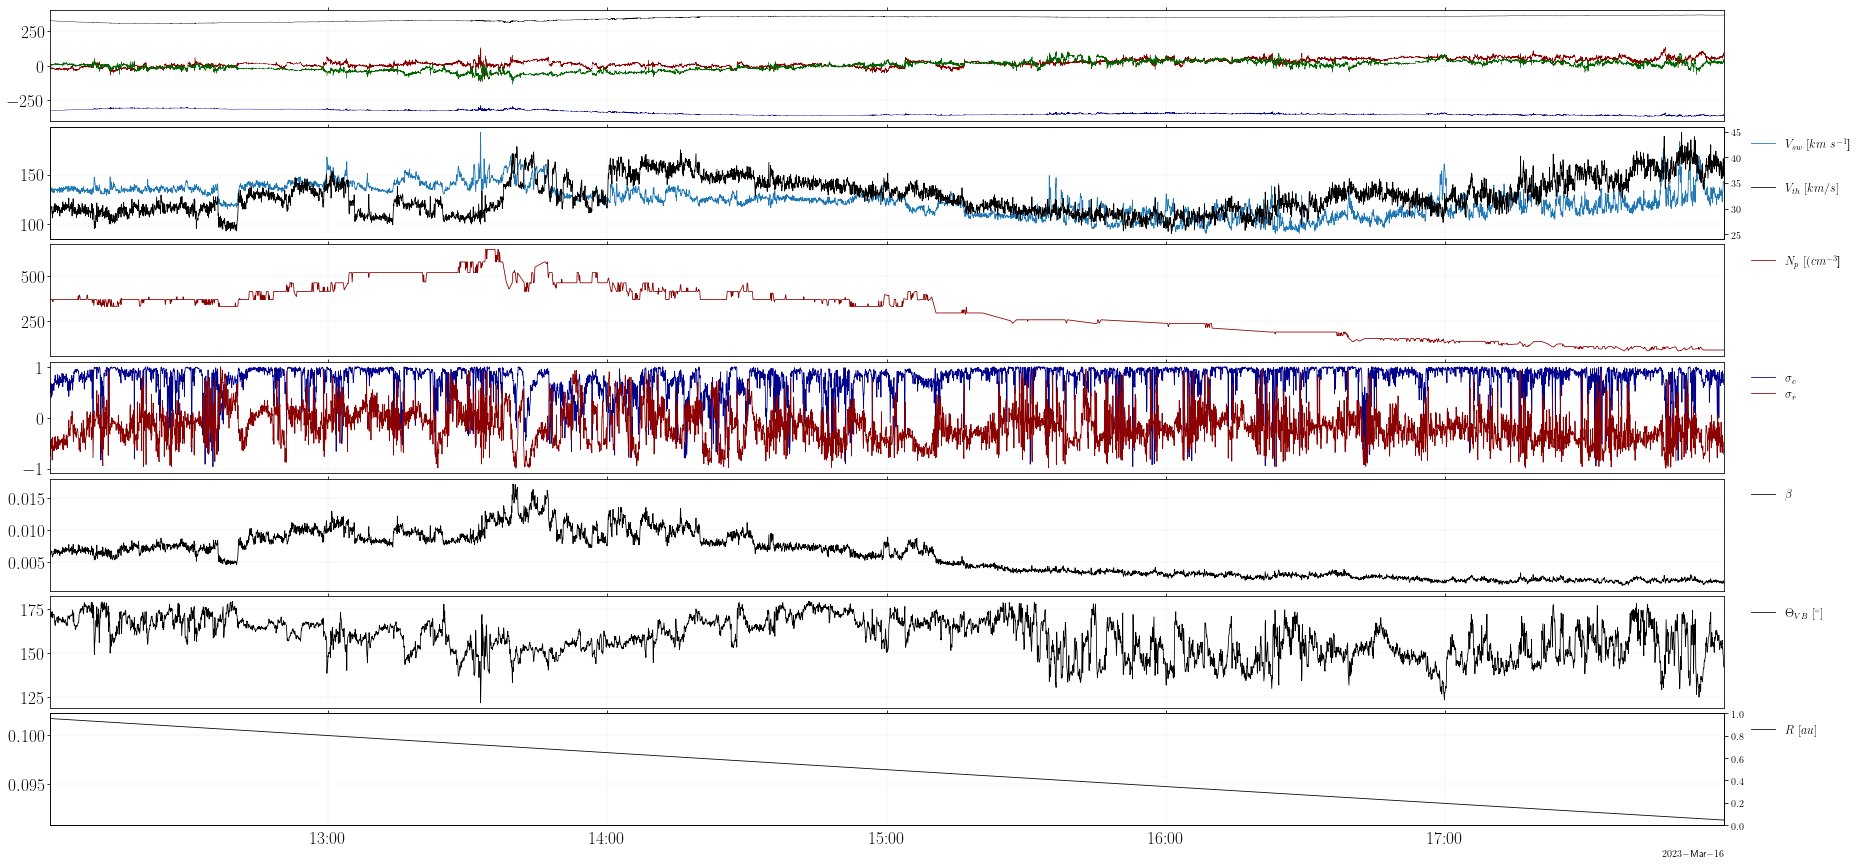

In [59]:
# user defined parameters
sc                = 'PSP'
label_size        = 21                                    # labels etc

n_subplots        = 7                                     # number os subplots
my_dir            = '/Users/nokni/work/MHDTurbPy/examples/' #
format_2_return   = "%Y_%m_%d"                            # Format to save figures


figs.visualize_downloaded_intervals(
                                  sc                         ,
                                  fin['Par']['V_resampled'],
                                  fin['Mag']['B_resampled'],
                                  sig     ,
                                  my_dir,
                                  format_2_return  = "%Y_%m_%d",  #
                                  size             = label_size,
                                  numb_subplots    = n_subplots
                                 )



# Estimate Power Spectral Density (PSD) of the magnetic field.
 - When using high resolution data, 'smoothing_function' is going to be slow!

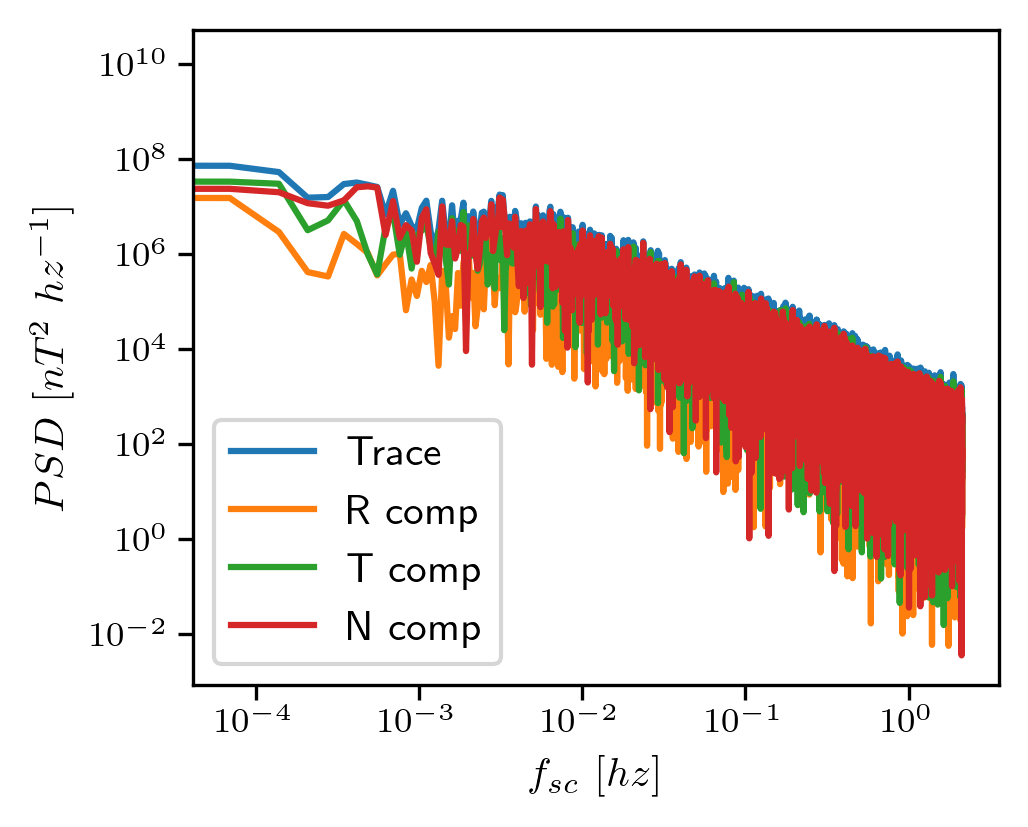

In [540]:
fig, ax =figs.initializeFigure(r'$PSD ~[nT^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig'], label ='Trace')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_R'], label ='R comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_T'], label ='T comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_N'], label ='N comp')

plt.legend()

# Plot estimated power spectra for several quantities


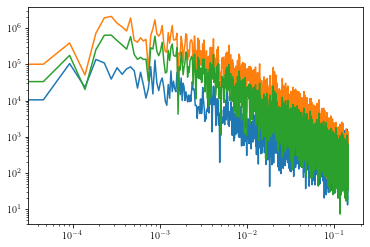

In [6]:
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_zm'])
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_zp'])
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_b'])

In [75]:
nv = 8



Vtot = fin['Par']['Vsw_mean']
di   = fin['Par']['di_mean']


V  = fin['Par']['V_resampled'][['Vr', 'Vt', 'Vn']]
B = fin['Mag']['B_resampled_part_res'][['Br', 'Bt', 'Bn']]

V   = func.newindex(V, B.index)
sig = func.newindex(sig, B.index)


B = (B.T*(sig['kin_norm'].values)).T




# Find cadence
dt = func.find_cadence(B)



_, _, _, _, freqs, PSDB, _ ,_           = turb.trace_PSD_cwt_ssqueezepy(B.Br.values, B.Bt.values, B.Bn.values,dt, scales_type   = 'log',nv            = nv)
_, _, _, _,  freqsV, PSDV, _ ,_         = turb.trace_PSD_cwt_ssqueezepy(V.Vr.values, V.Vt.values, V.Vn.values,dt, scales_type   = 'log',nv            = nv)



sign_Br = np.sign(B.Br.rolling('60min', center=True).mean().values)
 

Zp  = V.values - ((-sign_Br)*B.values.T).T
Zm  = V.values + ((-sign_Br)*B.values.T).T



_, _, _, _, freqszp, PSDzp,_ ,_ = turb.trace_PSD_cwt_ssqueezepy(Zp.T[0],   Zp.T[1], Zp.T[2], dt, scales_type   = 'log',nv            = nv)
_, _, _, _, freqszm, PSDzm, _ ,_  = turb.trace_PSD_cwt_ssqueezepy(Zm.T[0], Zm.T[1], Zm.T[2], dt, scales_type   = 'log',nv            = nv)




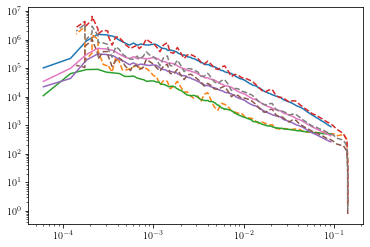

In [76]:
smzp =func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_zp'])
smzm =func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_zm'])


smv =func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])
smb =func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_b'])


plt.loglog(smzp[0], smzp[1], ms=0, ls='-')
plt.loglog(freqszp, PSDzp, ms=0, ls='--')


plt.loglog(smzm[0], smzm[1], ms=0, ls='-')
plt.loglog(freqszm, PSDzm, ms=0, ls='--')


plt.loglog(smv[0], smv[1], ms=0, ls='-')
plt.loglog(freqsV, PSDV, ms=0, ls='--')

plt.loglog(smb[0], smb[1], ms=0, ls='-')
plt.loglog(freqsV, PSDB, ms=0, ls='--')

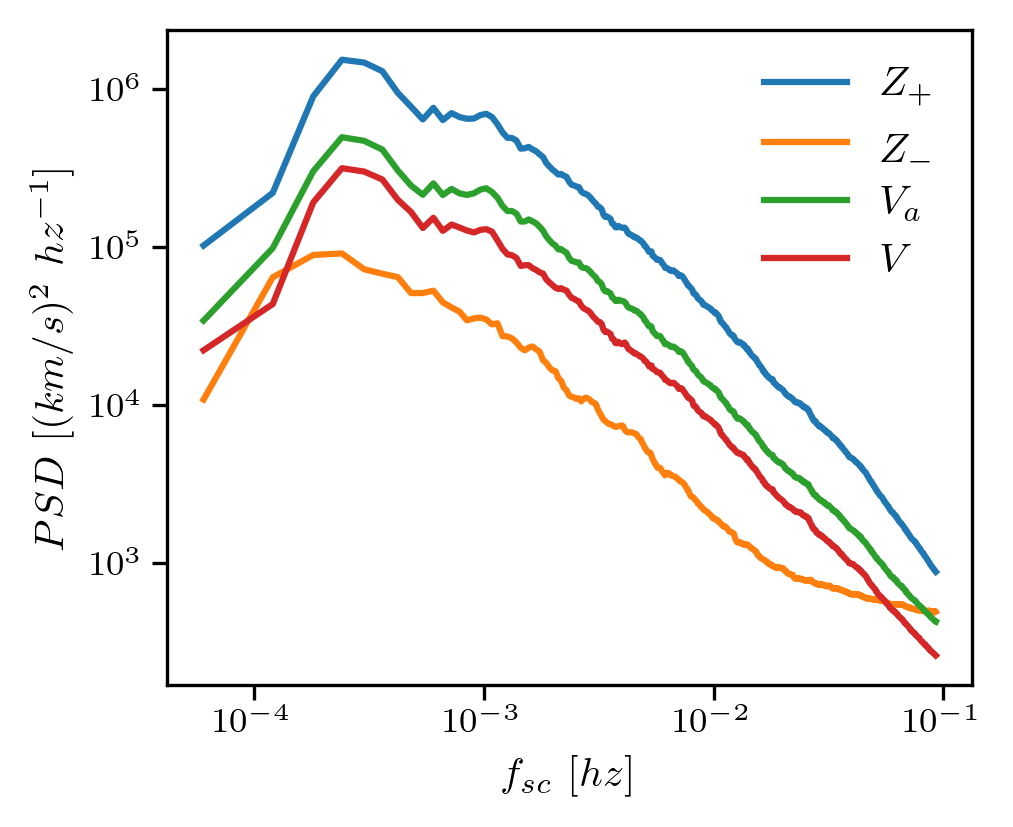

In [77]:
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(zp[0], zp[1], label =r'$Z_{+}$')
plt.loglog(zm[0], zm[1], label =r'$Z_{-}$')

plt.loglog(b[0], b[1], label =r'$V_a$')
plt.loglog(v[0], v[1], label =r'$V$')


# plt.loglog(zpa[0], zpa[1], label =r'$\delta Z_{+}$', ls='--')

# plt.loglog(zma[0], zma[1], label =r'$\delta Z_{-}$', ls='--')

# plt.loglog(ba[0], ba[1], label =r'$\delta V_a$', ls='--')
# plt.loglog(va[0], va[1], label =r'$\delta V$', ls='--')


# plt.loglog(zpb[0], zpb[1], label =r'$\delta Z_{+}$', ls=':')
# plt.loglog(zmb[0], zmb[1], label =r'$\delta Z_{-}$', ls=':')

# plt.loglog(bb[0], bb[1], label =r'$\delta V_a$', ls=':')
# plt.loglog(vb[0], vb[1], label =r'$\delta V$', ls=':')
plt.legend(frameon=0, loc=1)

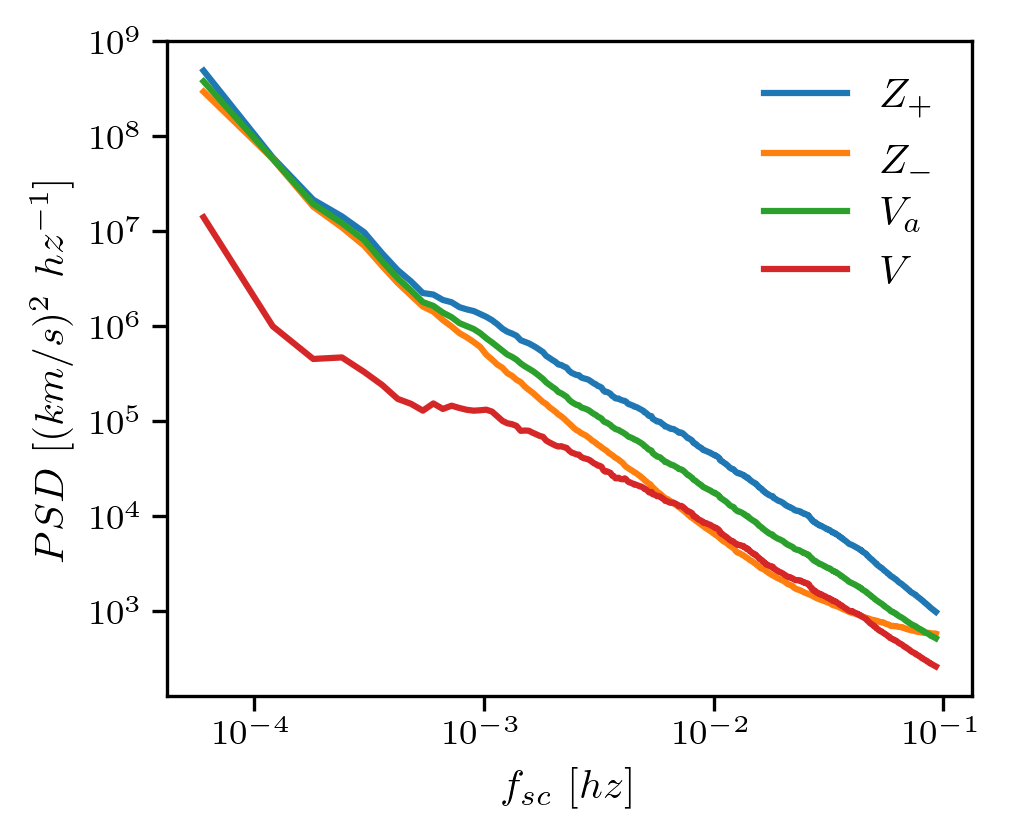

In [25]:
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(zp[0], zp[1], label =r'$Z_{+}$')
plt.loglog(zm[0], zm[1], label =r'$Z_{-}$')

plt.loglog(b[0], b[1], label =r'$V_a$')
plt.loglog(v[0], v[1], label =r'$V$')


# plt.loglog(zpa[0], zpa[1], label =r'$\delta Z_{+}$', ls='--')

# plt.loglog(zma[0], zma[1], label =r'$\delta Z_{-}$', ls='--')

# plt.loglog(ba[0], ba[1], label =r'$\delta V_a$', ls='--')
# plt.loglog(va[0], va[1], label =r'$\delta V$', ls='--')


# plt.loglog(zpb[0], zpb[1], label =r'$\delta Z_{+}$', ls=':')
# plt.loglog(zmb[0], zmb[1], label =r'$\delta Z_{-}$', ls=':')

# plt.loglog(bb[0], bb[1], label =r'$\delta V_a$', ls=':')
# plt.loglog(vb[0], vb[1], label =r'$\delta V$', ls=':')
plt.legend(frameon=0, loc=1)

# Estimate local scaling index

In [ ]:
import numpy as np

def mov_fit_func(xx, yy, w_size=10, xmin=None, xmax=None, keep_plot=False, adaptive_padding=False):
    """
    Perform moving fits on the data within a specified range, with optional adaptive padding.

    Parameters
    ----------
    xx : ndarray
        Input array representing the independent variable (x).
    yy : ndarray
        Input array representing the dependent variable (y).
    w_size : float
        Window size used to perform the fits.
    xmin : float, optional
        Minimum value of x for the fitting range.
    xmax : float, optional
        Maximum value of x for the fitting range.
    keep_plot : bool, optional
        If True, additional data for plotting fits is returned.
    adaptive_padding : bool or dict, optional
        Specifies the adaptive padding rules. If False, no adaptive padding is applied.
        If a dict, it follows the structure {'x_pad1': value, 'pad1': pad for x < x_pad1, 'pad2': pad for x > x_pad1}.

    Returns
    -------
    dict
        A dictionary containing information about the fits.
    """
    def adaptive_pad(x):
        """Determine padding based on x using adaptive padding rules."""
        if isinstance(adaptive_padding, dict) and 'x_pad1' in adaptive_padding:

            return adaptive_padding['pad1'] if x < adaptive_padding['x_pad1'] else adaptive_padding['pad2']
        return 1

    # Set default xmin and xmax if not provided
    if xmin is None:
        xmin = 0.1 * np.nanmin(xx)
    if xmax is None:
        xmax = 10 * np.nanmax(xx)

    # Filter out data outside of the specified range
    valid_indices = np.where((xx >= xmin) & (xx <= xmax))[0]
    if not valid_indices.size:
        return {'xvals': [], 'plaw': [], 'fit_err': [], 'plot_x': [], 'plot_y': []}

    result = {'xvals': [], 'plaw': [], 'fit_err': []}
    if keep_plot:
        result.update({'plot_x': [], 'plot_y': []})

    i = 0
    while i < len(valid_indices):
        idx = valid_indices[i]
        x0, xf = xx[idx], xx[idx] * w_size

        if xf >= 0.98 * xmax:
            i += 1
            continue

        # This part assumes the existence of func.find_fit function that you'll need to define or replace with your fitting logic
        fit, s, e, x1, y1 = func.find_fit(xx, yy, x0, xf)
        if len(x1):
            result['xvals'].append(x1[s])
            result['plaw'].append(fit[0][1])  # Example: fit results
            result['fit_err'].append(np.sqrt(fit[1][1][1]))  # Example: error calculation

            if keep_plot:
                result['plot_x'].append(x1[s:e])
                result['plot_y'].append(2 * fit[2])  # Example: adjusted fit data for plotting

        # Increment i by the adaptive padding for the current x-value
        i += adaptive_pad(xx[idx])

    # Convert lists to arrays for consistency
    for key in result:
        result[key] = np.array(result[key])

    return result


In [ ]:
fit_window = 5
xmin, xmax = 1e-8, 1e2
y_keys     = ['psd_zp', 'psd_zm', 'psd_b', 'psd_v']
labels     = [r'$Z_{+}$', r'$Z_{-}$', r'$V_a$', r'$V$']
adaptive_padding = { 'x_pad1': 5e-3, 
                     'pad1'  : 1,
                     'pad2'  : 10}

fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')
plt.yscale('linear')

for y_key, label in zip(y_keys, labels):
    print('Working on:', y_key)
 
    # Apply moving fit, using padding to make function faster (default, pad=1, i.e., do not skip any points during fitting process)
    fit  = mov_fit_func(fin['Par']['dict_psd']['f_zpm'],
                         fin['Par']['dict_psd'][y_key],
                         w_size           = fit_window,
                         xmin             = xmin,
                         xmax             = xmax,
                         adaptive_padding = adaptive_padding)

    plt.semilogx(fit['xvals'], fit['plaw'], label =label)

    plt.legend(frameon=0)
    
    plt.ylim([-2, -0.5])

# Smooth and fit the PSD

In [ ]:
V = fin['Par']['V_resampled'][['Vr', 'Vt', 'Vn']]# - fin['Par']['V_resampled'][['sc_vel_r', 'sc_vel_t', 'sc_vel_n']].values
Vr = fin['Par']['V_resampled'][['Vr', 'Vt', 'Vn']] - fin['Par']['V_resampled'][['sc_vel_r', 'sc_vel_t', 'sc_vel_n']].values
B = fin['Mag'][ 'B_resampled'][['Br', 'Bt', 'Bn']]#.values

In [ ]:
np.nanmean(V), np.nanmean(Vr)

In [524]:
load_path               ='/Volumes/GroupSSD/nsioulas/2d_anisotropy/PSP_all_fast_intervals'

general       = np.sort(glob(str(Path(load_path).joinpath("*").joinpath("wavelet_data_*.pkl"))))

print(len(general))

70


In [674]:
sc

'PSP'

In [ ]:
import traceback

"""User defined parameters"""

njobs                  = 7
choose_data            = 'PSP_fast'
thresholds             = {'mis_frac_part': 25, 'mis_frac_mag': 20, 'Resol_part': 30000, 'Resol_mag': 300}


overwrite_existing_files = 1

start_point, final_point = 0, 500
consider_Vsc             = 0
consider_Va              = 0
dj                       = 1/4
PSDthresholds            = {'5':[ 85, 5], '10':[ 80, 10]}
credentials              = { 'psp':{
                                       'fields': {'username': 'mvelli', 'password': 'flds@psp'},
                                       'sweap' : {'username': 'mvelli', 'password': '2019swe@pd@ta'}
                                      }
                              }


load_path               ='/Users/nokni/work/MHDTurbPy/examples/PSP/'  # In case you have multiple days you want to download ()


# Find paths of files
general       = np.sort(glob(str(Path(load_path).joinpath("*").joinpath("general.pkl"))))
final         = np.sort(glob(str(Path(load_path).joinpath("*").joinpath("final.pkl"))))


for i1 in range(start_point, len(final)):
    print(i1)

    # Construct the file pattern to match
    check_file_pattern = final[i1].replace("final.pkl", 'wavelet_data_*.pkl')

    # Check for existing files matching the pattern
    matching_files = glob(check_file_pattern)

    if (not matching_files) or (overwrite_existing_files):

        try:
            print('Progress', np.round(100*i1/(final_point-start_point),2),"(%)")


            fin1       = pd.read_pickle(final[i1])
            gen1       = pd.read_pickle(general[i1])


            # User defined parameters
            B_df                   = fin1['Mag']['B_resampled']
            V_df                   = fin1['Par']['V_resampled']

            # Reindex
            V_df                   = func.newindex(V_df, B_df.index)
            sigs                   = func.newindex(sig, B_df.index)

            """ Select h_many_hours interaval"""
            hmany_hours_fit       = round((B_df.index[-1]- B_df.index[0])/np.timedelta64(1, 's')/3600)

            if hmany_hours_fit>15:
                hmany_times = 3

            else:
                hmany_times = 1


            for io in range(hmany_times):
                if hmany_hours_fit>15:
                    print('>15', hmany_hours_fit)
                    if io==0:
                        tstart = B_df.index[0]
                        tend   = B_df.index[int(0.4*len(B_df.index.values))]
                    if io==1:
                        tstart = B_df.index[int(0.2*len(B_df.index.values))]
                        tend   = B_df.index[int(0.6*len(B_df.index.values))]        
                    if io==2:
                        tstart = B_df.index[int(0.6*len(B_df.index.values))]
                        tend   = B_df.index[int(len(B_df.index.values))]                         
                    

                else:
                        tstart = B_df.index[0]
                        tend   = B_df.index[-1]

                # Find start and end indices
                r2, r2a = func.find_ind_of_closest_dates(B_df,[tstart, tend] )


                print(r2, r2a)
                if ((gen1['Resolution_MAG']         < thresholds['Resol_mag'])       &
                    (gen1['Fraction_missing_MAG']   < thresholds['mis_frac_mag'])):

                    if (consider_Vsc):
                        
                        if (consider_Va):
                            
                            va_fac = "vsc_va"
                            V_df[['Vr', 'Vt', 'Vn']]  = V_df[['Vr', 'Vt', 'Vn']] +  (B_df[['Br', 'Bt', 'Bn']].values.T*sigs['kin_norm'].values).T- V_df[['sc_vel_r', 'sc_vel_t', 'sc_vel_n']].values
                        else:
                            va_fac = "vsc_no_va"
                            V_df[['Vr', 'Vt', 'Vn']]  = V_df[['Vr', 'Vt', 'Vn']]- V_df[['sc_vel_r', 'sc_vel_t', 'sc_vel_n']].values
                

                        # Keep Vsw to normalize
                        Vsw_norm                  = np.nanmean(np.sqrt(V_df['Vr']**2 + V_df[ 'Vt']**2  + V_df['Vn']**2).values)
                        di_norm                   = 228/np.sqrt(np.nanmean(V_df['np']))
                    else:
                        va_fac = "no_vsc"
                        Vsw_norm                  = np.nan
                        di_norm                   = np.nan

                    # Intialize PSD
                    keep_psd = {}

                    # Estimate cadence of mag field timeseries
                    dt                  = func.find_cadence(B_df[r2:r2a])



                    if  ((gen1['Resolution_part']       < thresholds['Resol_part'])      &
                        (gen1['Fraction_missing_part']  < thresholds['mis_frac_part'])):

                        # Estimate perp and par spectra

                        for kj in list(PSDthresholds.keys()):


                            freqs, PSD_par, PSD_per, PSD_par_mod, PSD_per_mod, scales = turb.psd_waveletes_anisotropic_analysis(B_df[r2:r2a][['Br', 'Bt', 'Bn']],
                                                                                                                                V_df[r2:r2a][['Vr', 'Vt', 'Vn']],
                                                                                                                                 dj,
                                                                                                                                 est_mod   = False,
                                                                                                                                 per_thresh= PSDthresholds[kj][0], 
                                                                                                                                 par_thresh= PSDthresholds[kj][1],
                                                                                                                                 njobs          = njobs)


                            # Save spectra
                            keep_psd[kj] = {'par':PSD_par, 'per':PSD_per}

                        angle_flag ='VB'


                        keep_data ={
                                    'PSDs'     : keep_psd,
                                    'f'        : freqs,
                                    'sig_c'    : fin1['Par']['sigma_c_mean'],
                                    'sig_r'    : fin1['Par']['sigma_r_mean'],
                                    'Vsw'      : fin1['Par']['Vsw_mean'],
                                    'di'       : fin1['Par']['di_mean'],
                                    'Vsw_norm' : Vsw_norm,
                                    'di_norm'  : di_norm,
                                    'beta'     : fin1['Par']['beta_mean'],
                                    'VB_or_RB' : angle_flag, 
                                    'd'        : gen1['d'],
                                    'Miss_par' : gen1['Fraction_missing_part'] ,
                                    'Miss_mag' : gen1['Fraction_missing_MAG']
                                   }


                        try:
                            func.savepickle(keep_data, final[i1].replace("final.pkl", ""), 'wavelet_data_'+ va_fac+"_"+str(io+1)+'.pkl')


                        except:
                            traceback.print_exc()
                            print("%s - %s failed!" %(i1, int(final_point-start_point)))
                            pass
        except:
            traceback.print_exc()
            print("%s - %s failed!" %(i1, int(final_point-start_point)))






17-May-24 18:52:41: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb7e867f700>
  pid = os.fork()

17-May-24 18:52:51: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb7d9d84e20>
  pid = os.fork()

17-May-24 18:53:01: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb7e867f8e0>
  pid = os.fork()

17-May-24 18:53:11: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:37: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb7e867eaa0>
  pid = os.fork()



412

In [252]:
 np.arange(0.0, 1.2, 0.15)

array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05])

In [ ]:
load_path               ='/Users/nokni/work/MHDTurbPy/examples/PSP/'

load_path               ='/Volumes/GroupSSD/nsioulas/2d_anisotropy/*all_fast_intervals_low_res' 

general       = np.sort(glob(str(Path(load_path).joinpath("*").joinpath("wavelet_data_*.pkl"))))

print(len(general))

which ='10'

w =10


dists = np.arange(0.0, 1.2, 0.15)


nbins = 80
what  ='mean'
fin_dict ={}
for jj in range(1, len(dists)):
    
    try:
    
        kf            = []
        kp            = []
        
        kfper         = []
        kper          = []

        ratio         = []
        ratiox        = []
        for i in range( len(general)):



            r1 =pd.read_pickle(general[i])

            if (r1['d']>dists[jj-1]) & (r1['d']<dists[jj]):
                
                try:
                    ratio.append(np.array(r1['PSDs'][which]['per'])/np.array(r1['PSDs'][which]['par']))
                    ratiox.append(2*np.pi*r1['f']/r1['Vsw_norm']*r1['di_norm'])

                    g    = func.mov_fit_func(2*np.pi*r1['f']/r1['Vsw_norm']*r1['di_norm'], r1['PSDs'][which]['par'], w, 1e-5, 1e2)
                    gper = func.mov_fit_func(2*np.pi*r1['f']/r1['Vsw_norm']*r1['di_norm'], r1['PSDs'][which]['per'], w, 1e-5, 1e2)



                    kf.append(g['xvals'])
                    kp.append(g['plaw'])

                    kfper.append(gper['xvals'])
                    kper.append(gper['plaw'])
                except:
                    pass


        parx, pary = np.hstack(kf), np.hstack(kp)
        perx, pery = np.hstack(kfper), np.hstack(kper)
        fin        = func.binned_quantity(parx[(pary>-4) & (parx>5e-5)],pary[(pary>-4) & (parx>5e-5)], what =what, bins=nbins)
        finper     = func.binned_quantity(perx[(pery>-4) & (perx>5e-5)],pery[(pery>-4) & (perx>5e-5)], what =what, bins=nbins)


        ratx, raty = np.hstack(ratiox), np.hstack(ratio)
        finrat        = func.binned_quantity( ratx[ raty>1e-1], raty[ raty>1e-1], what =what, bins=nbins)

        fin_dict[dists[jj-1]] = {'par': fin, 'per': finper, 'rat':finrat}
    except:
        pass

24-May-24 23:17:22: /Users/nokni/opt/anaconda3/envs/numba/lib/python3.10/site-packages/colormaps/cmaps.py:24424: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return matplotlib.cm.get_cmap(cname)



0.0
0.15
0.3
0.44999999999999996


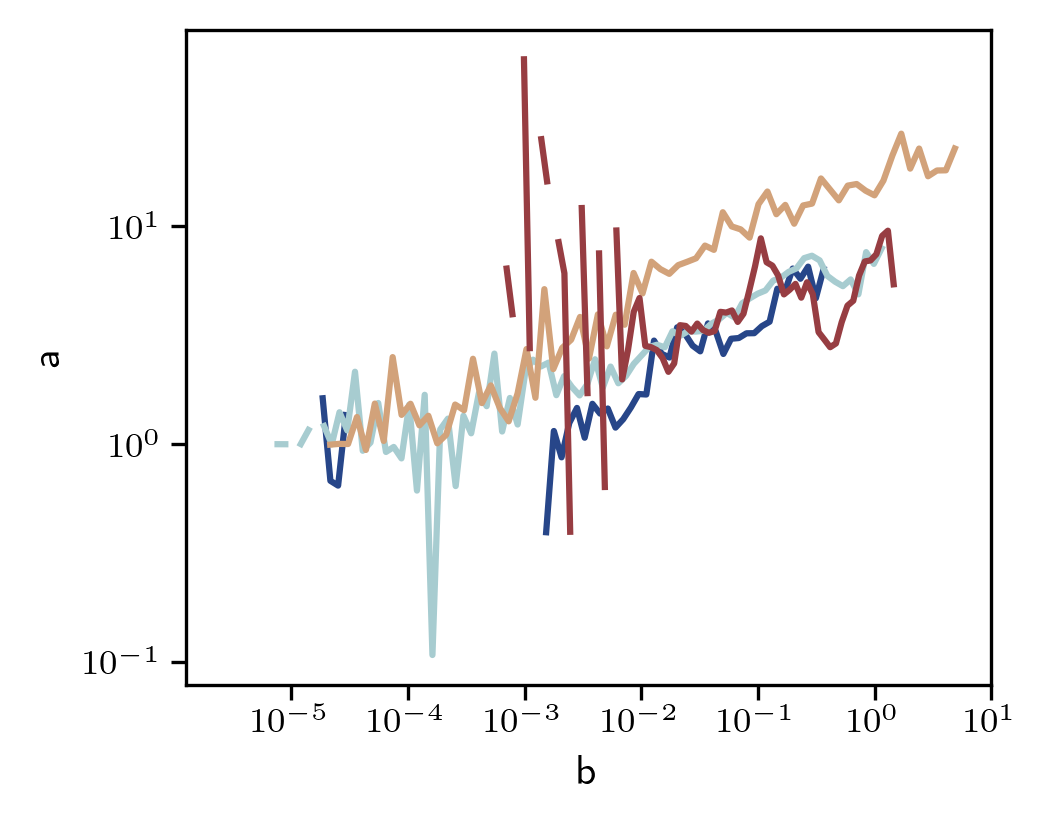

In [277]:
keys = list(fin_dict.keys())

fig, ax =figs.initializeFigure('a', 'b')
c =figs.create_colors(len(keys))
for jj, key in enumerate(keys):
    print(key)
    plt.loglog(fin_dict[key]['rat'][0], fin_dict[key]['rat'][1], c=c[jj])

0.0
0.15
0.3
0.44999999999999996


(-3.0, -0.5)

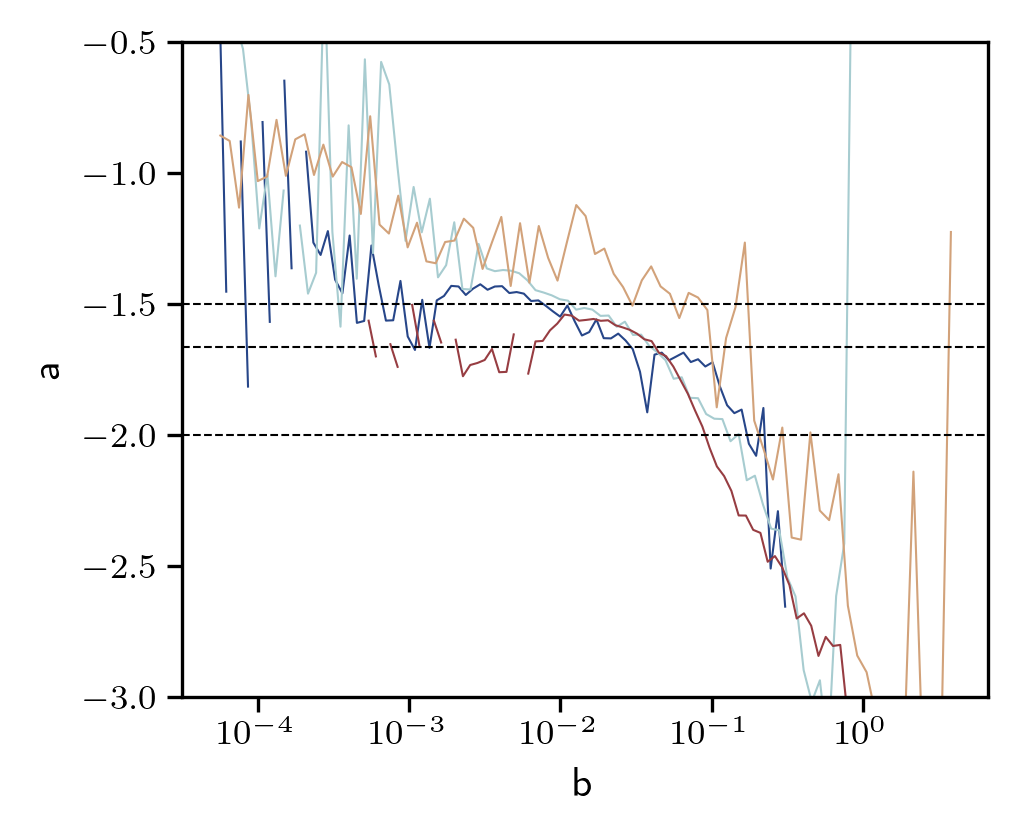

In [278]:
keys = list(fin_dict.keys())

fig, ax =figs.initializeFigure('a', 'b')

plt.yscale('linear')
c =figs.create_colors(len(keys))
for jj, key in enumerate(keys):
    print(key)
    plt.semilogx(fin_dict[key]['per'][0], fin_dict[key]['per'][1], c=c[jj], lw=0.5)
    
    
plt.axhline(y=-2, c='k', ls='--', lw=0.5)
plt.axhline(y=-3/2, c='k', ls='--', lw=0.5)
plt.axhline(y=-5/3, c='k', ls='--', lw=0.5)
plt.ylim([-3, -0.5])

0.0
0.15
0.3
0.44999999999999996


(-3.0, -0.5)

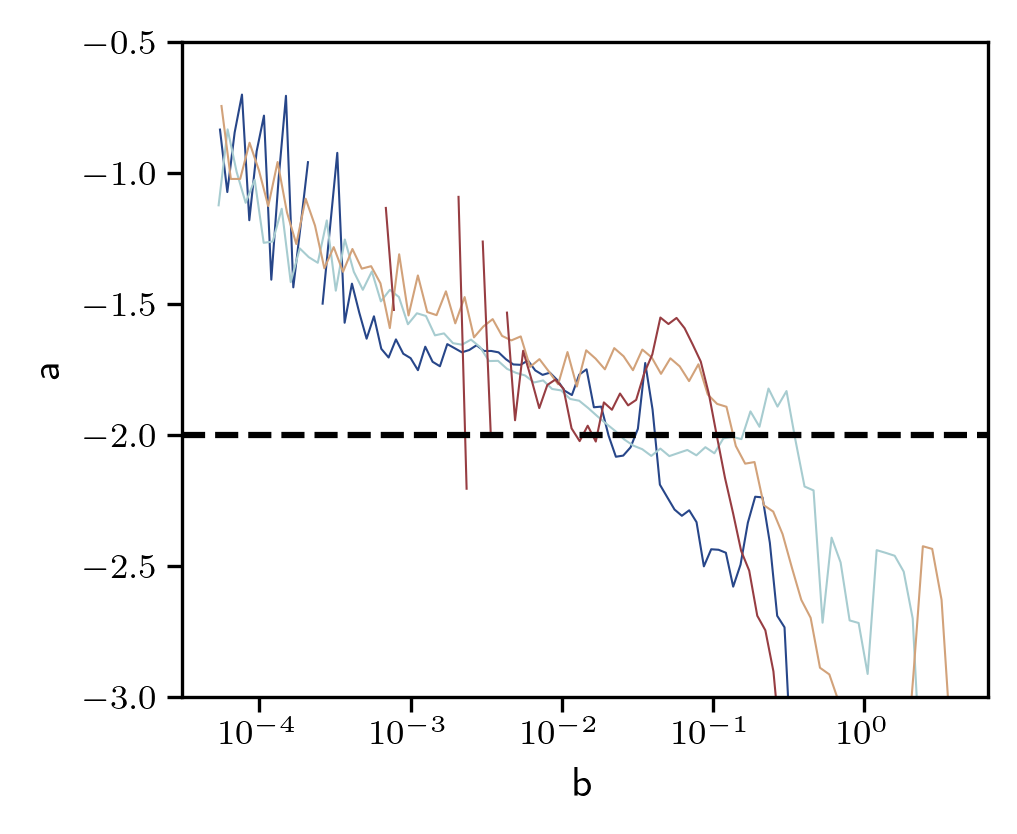

In [279]:
keys = list(fin_dict.keys())

fig, ax =figs.initializeFigure('a', 'b')

plt.yscale('linear')
c =figs.create_colors(len(keys))
for jj, key in enumerate(keys):
    print(key)
    plt.semilogx(fin_dict[key]['par'][0], fin_dict[key]['par'][1], c=c[jj], lw=0.5)
    
    
plt.axhline(y=-2, c='k', ls='--')


plt.ylim([-3, -0.5])

ValueError: need at least one array to concatenate

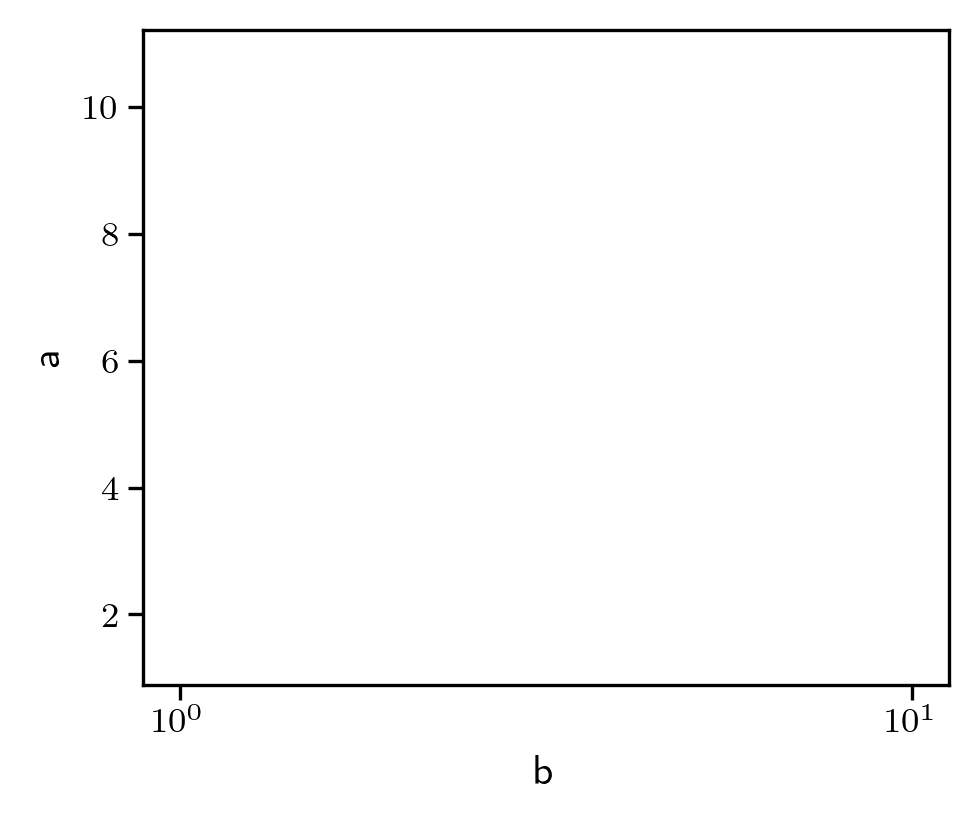

In [272]:
what  ='median'
nbins = 100

fig, ax= figs.initializeFigure('a', 'b')
plt.yscale('linear')
parx, pary = np.hstack(kf), np.hstack(kp)
fin = func.binned_quantity(parx[pary>-1e10],pary[pary>-1e10], what =what, bins=nbins)
finper = func.binned_quantity(np.hstack(kfper), np.hstack(kper), what =what, bins=nbins)

plt.semilogx(finper[0], finper[1])
plt.semilogx(fin[0], fin[1])



plt.axhline(y=-3/2)
plt.axhline(y=-5/3)
plt.axhline(y=-2)
plt.axhline(y=-1)

plt.axvline(x= 1e-2)
plt.ylim([-5, -0])

In [123]:
r1 =pd.read_pickle(general[0])
r2 =pd.read_pickle(general[1])
r3 =pd.read_pickle(general[2])

In [924]:
general[0]

'/Volumes/GroupSSD/nsioulas/2d_anisotropy/PSP_all_slow_intervals_low_res/2018-11-01_07-07-00_2018-11-02_10-53-00_sc_0/wavelet_data_vsc_va_1.pkl'

In [731]:
general[1]

'/Users/nokni/work/MHDTurbPy/examples/PSP/2018-11-05_12-30-00_2018-11-05_17-30-00_sc_0/wavelet_data_vsc_no_va_1.pkl'

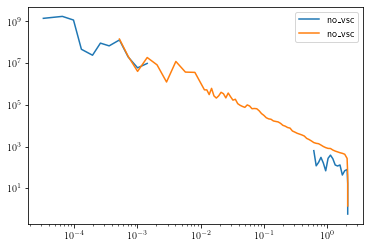

In [273]:
plt.loglog(r1['f'], r1['PSDs']['10']['par'], label ='no_vsc')
plt.loglog(r1['f'], r1['PSDs']['10']['per'], label ='no_vsc')


# plt.loglog(r2['f'], r2['PSDs']['10']['par'], ls='--', label ='vsc_no_va')
# plt.loglog(r2['f'], r2['PSDs']['10']['per'], label ='vsc_no_va')


# plt.loglog(r1['f'], r3['PSDs']['10']['par'], ls='--')
# plt.loglog(r1['f'], r3['PSDs']['10']['per'])


plt.legend()

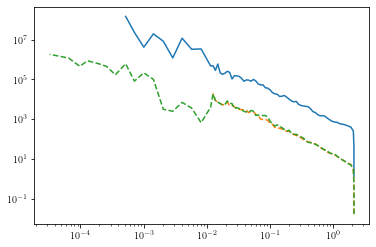

In [274]:
#plt.loglog(r1['f'], r1['PSDs']['5']['par'])
plt.loglog(r1['f'], r1['PSDs']['5']['per'])


#plt.loglog(r2['f'], r2['PSDs']['10']['par'], ls='--')
plt.loglog(r2['f'], r2['PSDs']['5']['per'], ls='--')




#plt.loglog(r1['f'], r3['PSDs']['5']['par'], ls='--')
plt.loglog(r1['f'], r3['PSDs']['5']['per'], ls='--')

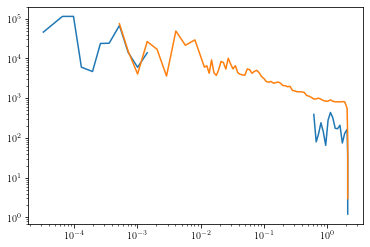

In [275]:
plt.loglog(r1['f'], r1['f']*r1['PSDs']['10']['par'])
plt.loglog(r1['f'], r1['f']*r1['PSDs']['10']['per'])

(-7.0, 0.0)

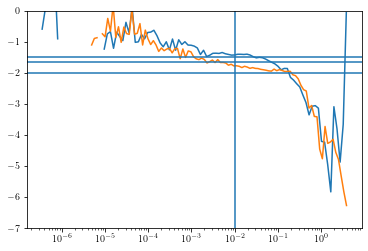

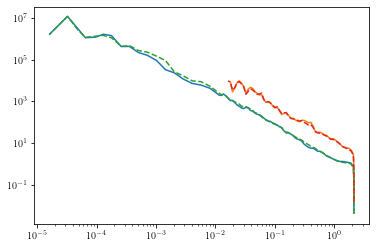

In [811]:
plt.loglog(r1['f'], r1['PSDs']['5']['par'])
plt.loglog(r1['f'], r1['PSDs']['5']['per'])

plt.loglog(r1['f'], r1['PSDs']['10']['par'], ls='--')
plt.loglog(r1['f'], r1['PSDs']['10']['per'], ls='--')

In [572]:
F = func.find_fit(r1['f'], r1['PSDs']['5']['par'], 2e-1, 8e-1)
F2 = func.find_fit(r1['f'], r1['PSDs']['5']['per'], 3e-1, 1e-0)
F[0][0][1], F2[0][0][1]

(-1.884642982413666, -1.8833890455220863)

No padding is used. You can change pad to make moving fit function faster (and increasingly less accurate)!
No padding is used. You can change pad to make moving fit function faster (and increasingly less accurate)!


(-6.0, 0.0)

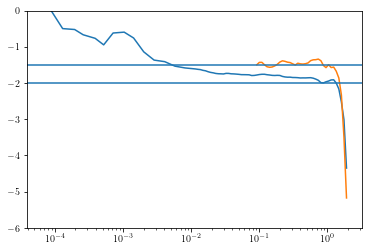

In [566]:
w =10

g =func.mov_fit_func(r1['f'], r1['PSDs']['10']['par'], w, 1e-5, 1e2)

plt.semilogx(g['xvals'], g['plaw'])

g =func.mov_fit_func(r1['f'], r1['PSDs']['10']['per'], w, 1e-5, 1e2)

plt.semilogx(g['xvals'], g['plaw'])
plt.axhline(y=-2)
plt.axhline(y=-3/2)

plt.ylim([-6, -0])

No padding is used. You can change pad to make moving fit function faster (and increasingly less accurate)!
No padding is used. You can change pad to make moving fit function faster (and increasingly less accurate)!


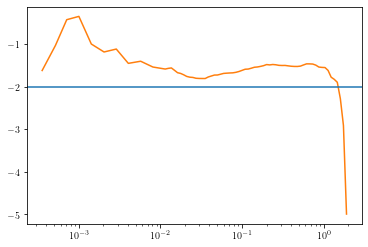

In [500]:
g =func.mov_fit_func(r1['f'], r1['PSDs']['5']['par'], 10, 1e-5, 1e2)

plt.semilogx(g['xvals'], g['plaw'])

g =func.mov_fit_func(r1['f'], r1['PSDs']['5']['per'], 10, 1e-5, 1e2)

plt.semilogx(g['xvals'], g['plaw'])
plt.axhline(y=-2)

In [ ]:
# Define fit range
x0, xf = 8e-4, 1e-2


# Initialize figure
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


# Smooth the PSD using a window of 2
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])



# Estimate fit 
fit, s, e, x, y = func.find_fit(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'], x0, xf)


# Add legend
lab_name =r'$\propto f^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit[0][1],2), round(np.sqrt(fit[1][1][1]),2))


# Plot everything
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])
plt.loglog(sm[0], sm[1], label ='smoothed')
plt.loglog(x[s:e],5*fit[2], 'k-.', lw=1.2, ls='-',label=lab_name) 



plt.legend(frameon=0)


# Plot normalized cross helicity and residual energy spectrum

In [ ]:
fig, ax =figs.initializeFigure(r'', r'$f_{sc} ~[hz]$')


zp = fin['Par']['dict_psd']['psd_zp']
zm = fin['Par']['dict_psd']['psd_zm']

va = fin['Par']['dict_psd']['psd_b']
v  = fin['Par']['dict_psd']['psd_v']

plt.yscale('linear')
plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (zp-zm)/(zp+zm), label =r'$\sigma_c$')
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], (zp-zm)/(zp+zm))
plt.semilogx(sm[0], sm[1],c='k')

plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (v-va)/(v+va), alpha=0.5,  label =r'$\sigma_r$')
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], (v-va)/(v+va))
plt.semilogx(sm[0], sm[1],c='k')

# Smooth the PSD using a window of 2

plt.axvline(fin['Par']['dict_psd']['f_zpm'][ind[0]])
plt.axhline(y=0)
plt.legend(frameon=0)

#  Estimate PVI Timeseries

In [ ]:
# User defined parameters
hours                  = 4                             # Averaging window in denominator (Hours)
hmany                  = [5, 100, 500]               # Estimate PVI timeseries using a lag of \ell =hmany*di
taus                   = None
B_df                   = fin['Mag']['B_resampled']
V_df                   = fin['Par']['V_resampled']

#
di                     = fin['Par']['di_mean']       # Mean value of ion inertial length for the interval
Vsw                    = fin['Par']['Vsw_mean']      # Mean value of Solar wind speed  for the interval

# Define figure labels
ylabel, xlabel         = r'$PVI$',  r"$Date$"
inset_f_size           = 7



# Run function
PVI_ts                 =turb.estimate_PVI(B_df,
                                           hmany, 
                                           taus,
                                           di,
                                           Vsw,
                                           hours,
                                           PVI_vec_or_mod='vec'
                                          )



# init Figure
fig, ax  = figs.initializeFigure(ylabel, xlabel, '1col')

for kk in range(len(hmany)):
    ax.plot(PVI_ts['PVI_'+str(hmany[kk])], ls='-', ms=0, lw=0.1, label =r'$PVI(\ell= {%d} d_{i})$'%(hmany[kk]))
    
    # # Estimate PDF of PVI
    # res =func.pdf(PVI_ts['PVI_'+str(hmany[kk])].dropna().values, nbins, loglog, density)
    # ax2.semilogy(res[0], res[1], ls='-', ms=0, lw=0.1,c ='C'+str(kk))
    # ax2.set_ylabel(r'$p(PVI)$')
    # ax2.set_ylabel(r'$PVI$')
    


ax.legend(loc=0, )
ax.set_ylim([0,None])


# Superposed epoch analysis
- For more information check (https://github.com/nsioulas/SEA)


In [ ]:
# user defined parameters
time_around        = '1000s'   # Time around identified events
which_one          =  'Vth'    # Parameter to be plotted on y axis
mean_or_median     =  0        # Estimate mean (1) or median (0) of events
resample_rate      =  '800ms'  # Cadence of joined timeseries
which_one_2_plot   = 0 


# you can actually aplly multiple conditions
condit_variables   = ['PVI_500']#, 'sigma_r']
conditions         = [['>=']]#, ['>=','<='] ]
threshold_values   = [[1]]#, [-0.15, 0.1]]


ylabel, xlabel     = r'$V_{th} ~[km/s]$',  r"$\delta \ell ~[d_i]$"


# Merge the two dfs
f_df = PVI_ts.resample(resample_rate ).mean().join(
     V_df.resample(resample_rate ).mean()
)


# run SEA function
results  = SEA(f_df,
              condit_variables,
              threshold_values,
              conditions,
              time_around,
              which_one,
              mean_or_median,
              resample_rate)


# Assign
keys =list(results.keys())
xvals, yvals, y_std, y_std_err_mean = results[keys[which_one_2_plot]]


# convert temporal lag to spatial and normalize with di
di_lag    = Vsw*xvals/di

# init Figure
fig, ax   = figs.initializeFigure(ylabel, xlabel, '1col')

ax.plot(di_lag, yvals, ls='-', ms=0, lw=0.1)
    